In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

from datetime import datetime

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Consutorias/Brasil Seg/data_raw/vendas_seguros.csv")

# Diagnóstico Estrutural – Base de Vendas

1. Estrutura Geral da Base
* Objetivo: Observar:
  * Quais colunas existem (columns);
  * Tipos de dados de cada variável (dtypes);
  * Frequência de tipos (quantas object, int64, float64, etc.).

* Utilidade:
  * Apoia o tratamento de variáveis categóricas e numéricas;
  * Verifica se datas ou identificadores estão com tipo adequado.
2. Dimensão do Dataset
* Verifica a quantidade total de registros e atributos, o que permite estimar a granularidade da base e seu potencial analítico.
3. Classificação das Variáveis Categóricas
* Objetivo: Listar os possíveis valores das variáveis categóricas principais:
  * tipo_produto: categorias de seguros vendidos;
  * canal_venda: canais de aquisição (app, * telefone, presencial etc.);
  * status: situação da venda (concluído, cancelado, pendente etc.).
* Aplicação:
  * Identificar inconsistências;
  * Preparar o tratamento (ex: codificação, agrupamento de categorias raras).
4. Visualização Inicial
* Exibe as primeiras linhas da base para:
  * Verificar possíveis erros de nomenclatura;
  * Validar se as variáveis estão corretamente preenchidas;
  * Antecipar necessidade de limpeza ou transformação.

In [4]:
df.columns.tolist()

['id_venda',
 'id_cliente',
 'tipo_produto',
 'canal_venda',
 'data_venda',
 'valor_premio',
 'status',
 'origem_interacao']

In [5]:
df.dtypes.tolist()

[dtype('int64'),
 dtype('int64'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('float64'),
 dtype('O'),
 dtype('int64')]

In [6]:
df.dtypes.value_counts()

,count
object,4
int64,3
float64,1


In [7]:
total_linhas = len(df)
total_colunas = len(df.columns)

print(f"Composição do DataFrame: {total_linhas} linhas e {total_colunas} colunas.")

Composição do DataFrame: 500 linhas e 8 colunas.


In [8]:
tipo_produto = df["tipo_produto"].unique()
canal_venda = df["canal_venda"].unique()
status = df["status"].unique()

print("*Variaveis categoricas*")
print(f"\n-Tipo de produto: {tipo_produto}")
print(f"-Canal de venda: {canal_venda}")
print(f"-Status: {status}")

*Variaveis categoricas*

-Tipo de produto: ['vida' 'auto' 'residencial' 'rural']
-Canal de venda: ['telefone' 'agência' 'app' 'parceiro']
-Status: ['efetivado' 'cancelado']


In [9]:
df.head()

,id_venda,id_cliente,tipo_produto,canal_venda,data_venda,valor_premio,status,origem_interacao
0,3000,1242,vida,telefone,2025-06-19,443.74,efetivado,2017
1,3001,1137,auto,agência,2025-06-17,87.23,efetivado,2164
2,3002,1078,residencial,agência,2025-06-13,461.79,efetivado,2524
3,3003,1169,vida,app,2025-06-13,182.01,cancelado,2201
4,3004,1122,vida,app,2025-06-26,270.81,efetivado,2740


#Validação Temporal da Variável data_venda
1. Conversão e Validação de Datas
* Objetivo: Converter a variável data_venda para o tipo datetime, tratando possíveis erros com NaT (errors='coerce').

* Importância:
  * Permite manipulação temporal (ex: agrupamentos, sazonalidade);
  * Evita falhas em operações de data posteriores.
2. Verificação de Datas Futuras (Inconsistência)
* Objetivo: Identificar registros com data_venda posterior à data atual, o que é geralmente considerado um erro de input.

* Ação esperada:
  * Revisar origem dos dados;
  * Corrigir ou excluir registros incoerentes, caso necessário.
3. Ordenação e Listagem de Datas de Venda
* Objetivo: Exibir a série de datas válidas presentes na base, de forma ordenada e formatada.

* Utilidade:
  * Confirmar período de abrangência temporal do dataset;
  * Identificar gaps, aglomerações ou padrões sazonais.

In [10]:
df["data_venda"] = pd.to_datetime(df["data_venda"], errors='coerce')

hoje = pd.Timestamp(datetime.today().date())

datas_futuras = df[df["data_venda"] > hoje]["data_venda"].unique()

if len(datas_futuras) > 0:
  print("Incoerencia identificada:")
  for d in sorted(datas_futuras):
    print(f"{d.date()}")
else:
      print("Não há data maior que atual")

Não há data maior que atual


In [11]:
datas_ordenadas = sorted(pd.to_datetime(df["data_venda"].unique()))
datas_formatadas = [d.strftime('%Y-%m-%d') for d in datas_ordenadas]

print(datas_formatadas)

['2025-06-01', '2025-06-02', '2025-06-03', '2025-06-04', '2025-06-05', '2025-06-06', '2025-06-07', '2025-06-08', '2025-06-09', '2025-06-10', '2025-06-11', '2025-06-12', '2025-06-13', '2025-06-14', '2025-06-15', '2025-06-16', '2025-06-17', '2025-06-18', '2025-06-19', '2025-06-20', '2025-06-21', '2025-06-22', '2025-06-23', '2025-06-24', '2025-06-25', '2025-06-26', '2025-06-27', '2025-06-28', '2025-06-29', '2025-06-30']


#Auditoria de Qualidade – Valores Nulos e Registros Duplicados
1. Análise de Nulos
* Objetivo: Quantificar e diagnosticar a presença de dados ausentes (NaN) na base.
* Importância:
  * Avaliar o impacto dos nulos na análise/modelagem;
  * Suporte a decisões sobre imputação, exclusão ou reconstrução dos dados.
* Insights possíveis:
  * Colunas com alto percentual de nulos podem ser descartadas ou requerer atenção especial;
  * Campos temporais ou financeiros com valores ausentes devem ser tratados com rigor adicional.
2. Identificação de Registros Duplicados
* Objetivo: Identificar duplicações com base em uma chave composta:
  * id_cliente, tipo_produto, data_venda.
* Utilidade:
  * Evitar superestimação de vendas;
  * Suporte a processos de deduplicação com lógica de negócio.
3. Agrupamento de Duplicatas
* Objetivo: Detectar clientes recorrentes em duplicações e verificar se há casos com múltiplos registros no mesmo dia/produto.
* Aplicação:
  * Avaliação da integridade da base para modelagem preditiva;
  * Suporte a políticas de governança de dados.

In [12]:
total_null = df.isna().sum().sum()
null_variavel = df.isna().sum()

perc_na = null_variavel / total_linhas * 100

print(f"-Total de valores Null: {total_null}")
print(f"-Distribuição percentual de Null por variavel: \n{perc_na}")

-Total de valores Null: 0
-Distribuição percentual de Null por variavel: 
id_venda            0.0
id_cliente          0.0
tipo_produto        0.0
canal_venda         0.0
data_venda          0.0
valor_premio        0.0
status              0.0
origem_interacao    0.0
dtype: float64


In [23]:
duplicadas = df[df.duplicated(subset=["id_cliente", "tipo_produto", "data_venda"], keep=False)]

duplicatas_count = (
    df.duplicated(subset=["id_cliente", "tipo_produto", "data_venda"], keep=False)
    .sum()
)

print(f"Total de registros duplicados encontrados: {duplicatas_count}")

print("Vendas duplicadas para o mesmo cliente, produto e data:")
print(duplicadas)

Total de registros duplicados encontrados: 8
Vendas duplicadas para o mesmo cliente, produto e data:
     id_venda  id_cliente tipo_produto canal_venda data_venda  valor_premio  \
141      3141        1028         vida    telefone 2025-06-23        207.41   
148      3148        1163         vida    telefone 2025-06-26        300.51   
170      3170        1023         vida     agência 2025-06-09        184.13   
184      3184        1023         vida     agência 2025-06-09        177.30   
211      3211        1078         vida     agência 2025-06-03        282.26   
236      3236        1163         vida         app 2025-06-26         52.45   
275      3275        1028         vida    parceiro 2025-06-23        113.07   
468      3468        1078         vida         app 2025-06-03        394.20   

        status  origem_interacao  
141  efetivado              2457  
148  efetivado              2036  
170  efetivado              2342  
184  efetivado              2491  
211  efetiva

In [24]:
duplicatas_grupo = (
    df[df.duplicated(subset=["id_cliente", "tipo_produto", "data_venda"], keep=False)]
    .groupby(["id_cliente", "tipo_produto", "data_venda"])
    .size()
    .reset_index(name="quantidade")
    .sort_values("quantidade", ascending=False)
)

print("Grupos com múltiplas vendas duplicadas:")
print(duplicatas_grupo)

Grupos com múltiplas vendas duplicadas:
   id_cliente tipo_produto data_venda  quantidade
0        1023         vida 2025-06-09           2
1        1028         vida 2025-06-23           2
2        1078         vida 2025-06-03           2
3        1163         vida 2025-06-26           2


#Distribuição Categórica – Produto, Canal e Status
* **Objetivo Geral**:
Avaliar a frequência absoluta e relativa das variáveis categóricas:
  * tipo_produto: categorias de seguros;
  * canal_venda: canais de aquisição;
  * status: situação atual da venda.

In [13]:
variaveis = ["tipo_produto", "canal_venda", "status"]

for var in variaveis:
    contagem = df[var].value_counts()
    percentual = df[var].value_counts(normalize=True) * 100

    resumo = pd.DataFrame({
        "quantidade": contagem,
        "percentual_%": percentual.round(2)
    })

    print(f"\n- {var.replace('_', ' ').title()}:")
    print(resumo)


- Tipo Produto:
              quantidade  percentual_%
tipo_produto                          
vida                 201          40.2
residencial          148          29.6
auto                 102          20.4
rural                 49           9.8

- Canal Venda:
             quantidade  percentual_%
canal_venda                          
app                 190          38.0
agência             127          25.4
telefone            102          20.4
parceiro             81          16.2

- Status:
           quantidade  percentual_%
status                             
efetivado         379          75.8
cancelado         121          24.2


#Análise de Eficiência por Produto e Canal de Venda
* **Objetivo**:
Avaliar o desempenho operacional (eficiência de conversão) por:
* Categoria de produto (tipo_produto);
* Canal de venda (canal_venda);

A eficiência é medida como a proporção de vendas efetivadas dentro do total registrado por grupo.

1. Eficiência por Tipo de Produto
* Agrupamento: número de registros por tipo_produto e status;
* Conversão (eficiencia_%)
2. Eficiência por Canal de Venda
* Interpretação:
  * Identifica canais com maior taxa de conversão;
  * Apoia decisões de investimento e otimização de canais.

In [14]:
produto_status = df.groupby(["tipo_produto", "status"]).size().unstack(fill_value=0)

produto_status["total"] = produto_status.sum(axis=1)
produto_status["eficiencia_%"] = (produto_status.get("efetivado", 0) / produto_status["total"]) * 100

print("Status por produto com eficiência (% efetivado):")
print(produto_status[["efetivado", "cancelado", "eficiencia_%"]].round(2))

Status por produto com eficiência (% efetivado):
status        efetivado  cancelado  eficiencia_%
tipo_produto                                    
auto                 84         18         82.35
residencial         113         35         76.35
rural                37         12         75.51
vida                145         56         72.14


In [15]:
canal_status = df.groupby(["canal_venda", "status"]).size().unstack(fill_value = 0)

canal_status["total"] = canal_status.sum(axis = 1)
canal_status["eficiencia_%"] = (canal_status.get("efetivado", 0) / canal_status["total"]) * 100

print("Status conversão por canal de venda (%)")
print(canal_status[["efetivado", "cancelado", "eficiencia_%"]].round(2))

Status conversão por canal de venda (%)
status       efetivado  cancelado  eficiencia_%
canal_venda                                    
agência             94         33         74.02
app                151         39         79.47
parceiro            63         18         77.78
telefone            71         31         69.61


#Análise Estatística e Financeira do Valor do Prêmio
**Objetivo**

Avaliar distribuições, médias e concentração de receita com base na variável valor_premio, segmentada por:
  * Produto (tipo_produto);
  * Canal (canal_venda);
  * Status (efetivado, cancelado, etc).
1. Estatísticas Gerais do Prêmio
* Métricas avaliadas: mínimo, média, máximo e quantidade de registros (count).
* Aplicação: compreende faixa de variação e volume da base monetária.
2. Estatísticas por Subgrupo
* Geração de estatísticas segmentadas por variável categórica.
* Identifica distribuições discrepantes, produtos de ticket médio mais alto, e canais/status com baixa volumetria de venda.
3. Distribuição do Valor Total por Status
* Finalidade: entender qual status concentra mais receita.
* Por exemplo, cancelado pode representar baixa conversão, mas alto volume potencial.
* Aplicação prática: priorização de recuperação de receita perdida ou otimização de canal.

In [16]:
stats_valor_premio = df["valor_premio"].agg(["min", "mean", "max", "count"]).round(2)
print("Estatísticas do valor do prêmio:")
print(stats_valor_premio)

Estatísticas do valor do prêmio:
min       52.43
mean     285.80
max      498.91
count    500.00
Name: valor_premio, dtype: float64


In [17]:
stats_premio_produto = df.groupby("tipo_produto")["valor_premio"].agg(["min", "mean", "max", "count"]).round(2)
print("Estatísticas do valor do prêmio por produto:")
print(stats_premio_produto)

Estatísticas do valor do prêmio por produto:
                min    mean     max  count
tipo_produto                              
auto          72.77  306.40  498.33    102
residencial   63.38  280.52  488.03    148
rural         59.02  293.61  498.91     49
vida          52.43  277.32  496.75    201


In [18]:
stats_premio_canal = df.groupby("canal_venda")["valor_premio"].agg(["min", "mean","max", "count"]).round(2)
print("Estatísticas do valor do prêmio por canal de venda:")
print(stats_premio_canal)

Estatísticas do valor do prêmio por canal de venda:
               min    mean     max  count
canal_venda                              
agência      52.43  287.65  496.75    127
app          52.45  293.36  498.91    190
parceiro     55.10  268.46  484.80     81
telefone     56.08  283.17  498.33    102


In [19]:
stats_premio_status = df.groupby("status")["valor_premio"].agg(["min", "mean", "max", "count"]).round(2)
print("Estatísticas do valor do prêmio por status:")
print(stats_premio_status)

Estatísticas do valor do prêmio por status:
             min    mean     max  count
status                                 
cancelado  52.45  285.76  498.33    121
efetivado  52.43  285.81  498.91    379


In [25]:
valor_status = df.groupby("status")["valor_premio"].sum()
valor_total = valor_status.sum()

percentual_status = (valor_status / valor_total * 100).round(2)

resumo_status = pd.DataFrame({
    "valor_total": valor_status,
    "percentual_%": percentual_status
})

print("Distribuição do valor de prêmio por status:")
print(f"Valor total: {valor_total}")
print(resumo_status)

Distribuição do valor de prêmio por status:
Valor total: 142899.14
           valor_total  percentual_%
status                              
cancelado     34577.54          24.2
efetivado    108321.60          75.8


#Análise Temporal da Receita de Prêmios
**Objetivo**
Monitorar a evolução diária da soma dos prêmios (valor_premio) e identificar tendências de crescimento ou retração na geração de receita ao longo do tempo.

1. Preparação e Agrupamento Diário
* Converte data_venda para formato datetime.
* Agrupa os valores de valor_premio por dia → receita total por data.
2. Taxa de Crescimento Percentual Diária
* Calcula a variação percentual diária entre os valores de prêmio
* Interpretação:
  * Valores positivos: aumento da receita;
  * Valores negativos: retração da receita;
  * Valores nulos/inf: ausência de base comparativa (ex: 1º dia).
3. Suavização com Média Móvel (7 dias)
* Aplica média móvel de 7 dias para suavizar oscilações diárias e destacar tendências estruturais.
* Boa prática em séries temporais para evitar ruído de curto prazo.

In [21]:
df["data_venda"] = pd.to_datetime(df["data_venda"])
premio_dia = df.groupby("data_venda")["valor_premio"].sum()

crescimento_premio = premio_dia.pct_change() *100

print("-Taxa de crscimento percentual")
print(crescimento_premio.round(2))

-Taxa de crscimento percentual
data_venda
2025-06-01      NaN
2025-06-02   -26.18
2025-06-03    -2.32
2025-06-04   -25.01
2025-06-05    11.07
2025-06-06   -10.74
2025-06-07     0.12
2025-06-08    -3.32
2025-06-09    93.90
2025-06-10    -6.55
2025-06-11   -28.96
2025-06-12    45.32
2025-06-13   -15.69
2025-06-14    12.80
2025-06-15    40.70
2025-06-16   -51.58
2025-06-17    17.30
2025-06-18    10.01
2025-06-19    34.93
2025-06-20   -20.29
2025-06-21   -24.19
2025-06-22    35.84
2025-06-23    -4.58
2025-06-24     4.82
2025-06-25     6.58
2025-06-26   -15.25
2025-06-27     6.30
2025-06-28   -19.08
2025-06-29    11.15
2025-06-30    45.09
Name: valor_premio, dtype: float64


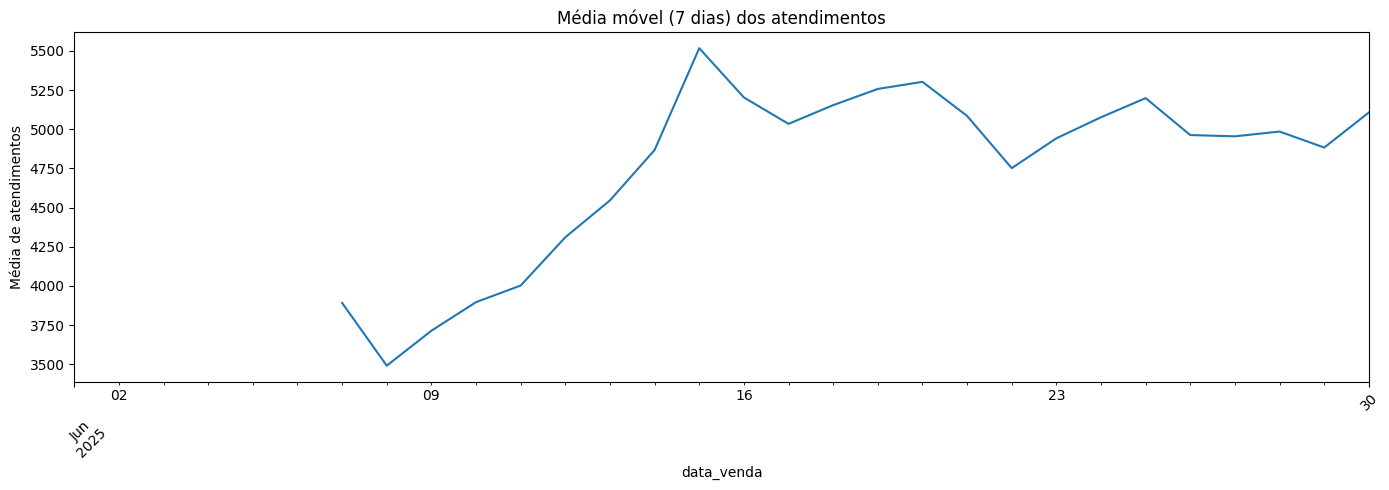

In [22]:
premio_dia.rolling(window=7).mean().plot(figsize=(14, 5), title="Média móvel (7 dias) dos atendimentos")
plt.xticks(rotation=45)
plt.ylabel("Média de atendimentos")
plt.tight_layout()
plt.show()

In [26]:
df["data_venda"] = pd.to_datetime(df["data_venda"])
premio_dia = df.groupby("data_venda")["valor_premio"].sum()
crescimento_premio = premio_dia.pct_change() * 100

quedas_criticas = crescimento_premio[crescimento_premio < -20].round(2)

print("Dias com queda crítica (> 20%) no valor do prêmio:")
print(quedas_criticas)

Dias com queda crítica (> 20%) no valor do prêmio:
data_venda
2025-06-02   -26.18
2025-06-04   -25.01
2025-06-11   -28.96
2025-06-16   -51.58
2025-06-20   -20.29
2025-06-21   -24.19
Name: valor_premio, dtype: float64
